In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from itertools import combinations
from itertools import chain
from collections import Counter
import seaborn as sns

import networkx as nx
from pyvis.network import Network
import community as community_louvain


# 1. Data preparation

In [2]:
df = pd.read_csv("Tags.csv")
df.columns = df.columns.str.lower()
df = df[df.tag != 'python']
df.head()

,id,tag
1,469,osx
2,469,fonts
3,469,photoshop
5,502,windows
6,502,image


How many tags are there? So many that it would create a giant dataset and giant network which wouldn't be visualizable properly anymore.

In [3]:
df.tag.nunique()

16894

We keep just the 100 most important tags.  
This is **very** important, as we don't want a gigantic network of thousands of connections.  
It would take days or weeks to solve and would be a giant CF.

In [4]:
'''# We want to have a Node dataset: 
 Node
 Tag name, Count, Centrality
 Pandas, 500, ...
 Numpy, 700, and some measure of importance.
 ... , ...
 We want some way to represent the Node size.
 We could measure all sorts of centralities.
 But also, how often does Pandas occur in the dataset. 500 times, 700 times, etc.?
 We need a tag and some measure of importance.

 We will also need an Edges dataset:
 Tag 1, Tag 2, Weight(Co-occurances), ...
 Pandas, (connected to) Numpy, 40, ...
 Pandas, (connected to) Matplotlib, 1000, ...
 ... , ...'''

nodes = df.value_counts('tag').reset_index().rename(columns = {0:'n'})

#nodes = nodes[nodes>=2000].reset_index().rename(columns = {0:'n'})

nodes['position'] = nodes.n.rank(ascending=False).astype(int)
nodes = nodes[nodes.position <=100]

df = df.merge(nodes.tag, how='inner', on='tag')
#df.shape
nodes

,tag,n,position
0,django,62818,1
1,python-2.7,34616,2
2,pandas,26854,3
3,python-3.x,26814,4
4,numpy,25848,5
...,...,...,...
95,api,2204,96
96,jquery,2158,97
97,kivy,2114,98
98,http,2108,99


We keep only Stackoverflow questions (id) where 2 or more tags are given

In [5]:
df

,id,tag
0,469,osx
1,3976,osx
2,13941,osx
3,29856,osx
4,51658,osx
...,...,...
621188,40131264,django-rest-framework
621189,40132625,django-rest-framework
621190,40133557,django-rest-framework
621191,40141190,django-rest-framework


We may want delete these first rows, as we only keep those where at least 2 tags are given!

In [6]:
df['n_tags'] = df.groupby('id').tag.transform('count')
df = df[df.n_tags>=2].reset_index().drop(columns = 'n_tags')
df.shape

(352665, 3)

Now instead of 600k we are left with 352k.

In [7]:
df.sort_values('id').head(10)

,index,id,tag
2816,5056,502,windows
5842,11323,502,image
7877,14217,594,sql
10629,17695,594,database
20816,29908,742,django
51328,92726,742,oop
52437,94977,766,mysql
57280,102506,766,postgresql
10630,17696,1734,database
59933,106097,1734,xml


Reshape such that 1 question represents 1 row


In [8]:
df['tag'] = df['tag'].astype(str)
df['tags'] = df.groupby(['id'])['tag'].transform(lambda x: ' '.join(x))
df = df.reset_index().drop_duplicates(subset='id')[['id', 'tags']].reset_index(drop=True)
df.tags = df.tags.map(str.split)
df.head()

,id,tags
0,3976,"[osx, linux]"
1,51658,"[osx, windows, linux]"
2,167439,"[osx, shell, bash]"
3,238882,"[osx, postgresql]"
4,249775,"[osx, linux]"


We'll first tag the pairs...

In [9]:
tag_pairs_per_text = [list(combinations(i, 2)) for i in df.tags]
all_tag_pairs = list(chain(*tag_pairs_per_text))
tag_pair_count = Counter(all_tag_pairs)
tag_pair_count

Counter({('osx', 'linux'): 119,
         ('osx', 'windows'): 106,
         ('windows', 'linux'): 259,
         ('osx', 'shell'): 51,
         ('osx', 'bash'): 86,
         ('shell', 'bash'): 519,
         ('osx', 'postgresql'): 34,
         ('osx', 'mysql'): 107,
         ('osx', 'apache'): 30,
         ('mysql', 'apache'): 47,
         ('osx', 'c'): 37,
         ('linux', 'c'): 104,
         ('osx', 'opencv'): 114,
         ('osx', 'ipython'): 59,
         ('osx', 'django'): 191,
         ('django', 'mysql'): 1696,
         ('osx', 'wxpython'): 85,
         ('osx', 'image'): 10,
         ('osx', 'module'): 47,
         ('osx', 'beautifulsoup'): 17,
         ('osx', 'python-imaging-library'): 51,
         ('osx', 'php'): 13,
         ('django', 'php'): 120,
         ('osx', 'unicode'): 31,
         ('osx', 'virtualenv'): 143,
         ('osx', 'database'): 1,
         ('database', 'django'): 859,
         ('osx', 'ubuntu'): 32,
         ('ubuntu', 'opencv'): 75,
         ('osx', 'c++'):

...and then we'll want to put this into a new dataset, or rather dataframe

In [10]:
edges = pd.DataFrame.from_dict(tag_pair_count, orient='index')
edges['tag1'], edges['tag2'] = zip(*edges.index)
edges.reset_index(inplace=True, drop=True)
edges = edges.rename(columns={0: 'value'}).sort_values('value', ascending=False)
cols = ['tag1', 'tag2', 'value']
edges = edges[cols]
edges

,tag1,tag2,value
313,django,django-models,5595
780,arrays,numpy,5307
388,dataframe,pandas,4564
75,numpy,scipy,3580
769,django,django-forms,2464
...,...,...,...
2442,oop,linux,1
2440,oop,nltk,1
2438,http,class,1
3654,html,scipy,1


Keep only the most important edges per node


In [11]:
edges = (edges
    .merge(nodes, how="inner", left_on="tag1", right_on="tag")
    .rename(columns={'n':'source_n'})
    .merge(nodes, how="inner", left_on="tag2", right_on="tag")
    .rename(columns={'n':'target_n'})
)

edges['tag1_share'] = edges.value / edges.source_n
edges['tag2_share'] = edges.value / edges.target_n

edges = edges.query('tag1_share>0.05 | tag2_share>0.05')
edges = edges[["tag1","tag2","value","tag1_share","tag2_share"]]
edges

,tag1,tag2,value,tag1_share,tag2_share
0,django,django-models,5595,0.089067,0.965154
20,django,django-forms,2464,0.039224,0.966654
34,django-models,django-forms,616,0.106262,0.241663
37,django-templates,django-forms,219,0.086391,0.085916
44,django-views,django-forms,357,0.161319,0.140055
...,...,...,...,...,...
4014,numpy,dataframe,290,0.011219,0.058491
4073,database,django,859,0.282287,0.013674
4074,sql,django,692,0.198965,0.011016
4076,image,django,206,0.071182,0.003279


Now are in a better situation. Only 249 rows, which we can start visualizing with!

# 2. Network Graph

In [12]:
G = nx.Graph()

'''We are then iterating over the edges and take the weight variable to connect over the widths of the edges
'''

for index, row in nodes.iterrows():
    G.add_node(row.tag, nodesize = row.n ) 
for index, row in edges.iterrows():
    G.add_edge(row.tag1, row.tag2, weight = row.value)

nx.info(G)

C:\Users\janni\AppData\Local\Temp\ipykernel_1608\2302827615.py:11: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G)


'Graph with 100 nodes and 249 edges'

# 3. Visualization


## 3.1 Static Visualization

There will be some trying out - before we get to a properly usable result.  
A lot of **fine-tuning** to adjust the node size is also necessary.  

The point is, this takes some **time** to fine-tune this in a way.

The location despicts the gravitational forces.

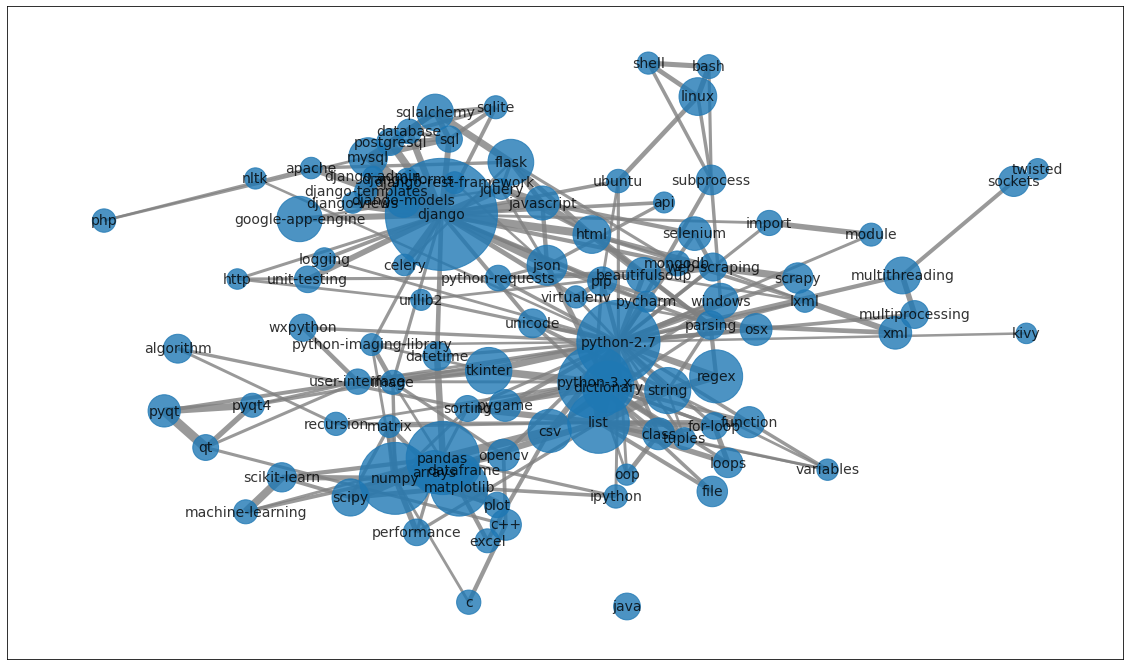

In [13]:
def draw_graph(G,size):
    plt.figure(figsize=size)   

    # Parameters
    '''
    There are different layouts we can play around with. Also with k=3, 4, blub, iterations, and so on!
    Also 'nodesize' is something to consider, and so on! If it gets too big it becomes unreadable. 
    '''
    # pos = nx.drawing.circular_layout(G) 
    pos = nx.drawing.spring_layout(G,k=3,iterations=60)
    node_size = [d['nodesize']*0.2 for _,d in G.nodes(data=True)]
    edge_width = [np.sqrt(d['weight']*0.05) for _,_,d in G.edges(data=True)]

    # Draw Network
    nx.draw_networkx(G,
        pos=pos,
        node_size=node_size,
        width=edge_width, 
        edge_color='grey',font_size= 14, alpha = 0.8)
    plt.show()

draw_graph(G,size=(20,12))

java is disconnected, but just because it does not have important connections. It appears more than 2000 times but there seems to be no connection to anything specific.  

So it would be good to present the most important link to a given tag.  

*For example, we could pose questions like: What would be the most important link for java?*

## 3.2 Visualize Commmunities

*What is the Louvain Algorithm doing?*  

Initially the nodes are each their own communities.  

Then it identifies "which are the two communities connected to each other, so that they can form one community?"  

He is looking for similarities. In this way, gradually, hierarchically, it is thus making the communities bigger and bigger.

In [14]:
## Visualize communities
partition = community_louvain.best_partition(G)
louvain_communities = pd.DataFrame.from_dict(partition, orient='index').reset_index().rename(columns = {'index':'tag', 0:'louvain'})
nodes = nodes.merge(louvain_communities, how='inner', on='tag')
nodes.head()

,tag,n,position,louvain
0,django,62818,1,7
1,python-2.7,34616,2,4
2,pandas,26854,3,3
3,python-3.x,26814,4,4
4,numpy,25848,5,3


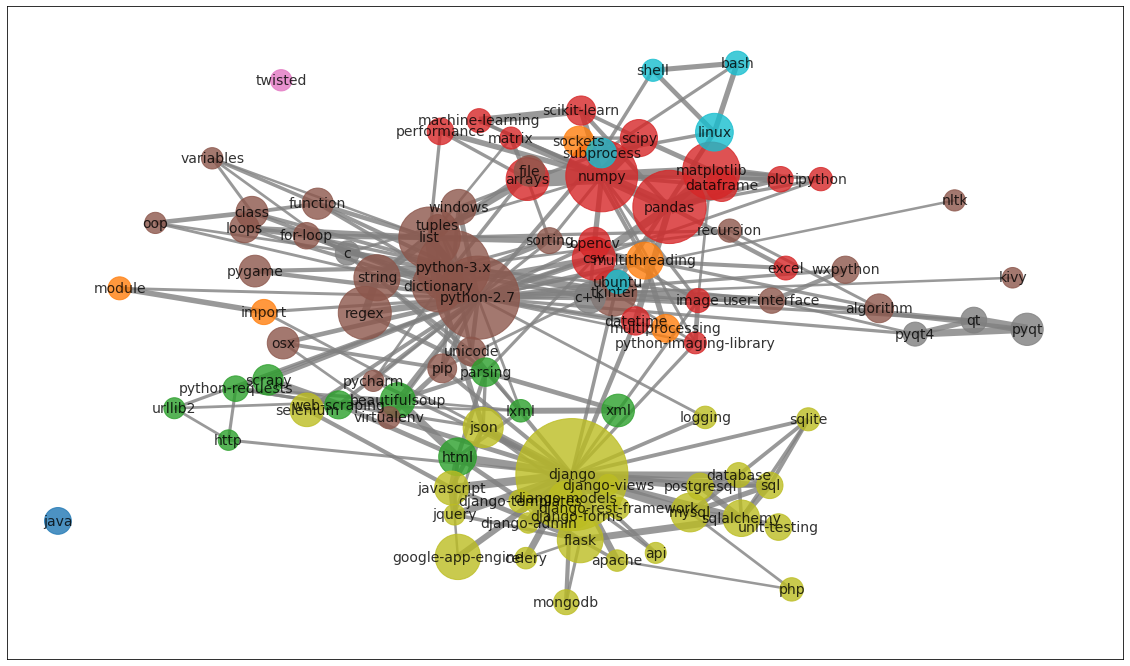

In [15]:
def draw_graph(G,size):
    plt.figure(figsize=size)   

    # Params 
    pos = nx.drawing.spring_layout(G,k=3,iterations=60)
    node_size = [d['nodesize']*0.2 for _,d in G.nodes(data=True)]
    edge_width = [np.sqrt(d['weight']*0.05) for _,_,d in G.edges(data=True)]
    cmap = cm.get_cmap('tab10', nodes.louvain.nunique())

    # Draw Network
    nx.draw_networkx(G,
        pos=pos,
        node_color=nodes.louvain, cmap = cmap,
        node_size=node_size,
        width=edge_width, 
        edge_color='grey',font_size= 14, alpha = 0.8)
    plt.show()

draw_graph(G,size=(20,12))

## 3.3 Interactive

In [16]:
nt = Network(height="600px", width="1200px")

# Nodes
for idx, row in nodes.iterrows():
    nt.add_node(
        n_id = row.tag, 
        value = row.n,
        group = row.louvain, 
        shape = 'dot', 
        title = f'Tag: {row.tag} \n Rank: {row.position}')

# Edges
for idx, row in edges.iterrows():
    nt.add_edge(row.tag1, row.tag2, value=row.value)

nt.show_buttons(filter_=['physics'])    # 'interaction','manipulation','physics', nodes, edges, physics
nt.show('stackoverflow.html')  


In [17]:
nt = Network(height="600px", width="1200px")

# Nodes
for idx, row in nodes.iterrows():
    nt.add_node(
        n_id = row.tag, 
        value = row.n,
        group = row.louvain, 
        shape = 'dot', 
        title = f'Tag: {row.tag} \n Rank: {row.position}')

# Edges
for idx, row in edges.iterrows():
    nt.add_edge(row.tag1, row.tag2, value=row.value)

nt.set_options("""
const options = {
  "interaction": {"keyboard": {"enabled": true},"navigationButtons": true},
  "physics": {"barnesHut": {"springLength": 400}},
  "nodes": {"font": {"size": 30}}
}""")
nt.show('stackoverflow.html')

# 4. Network Properties

## 4.1 Centrality Measures

Centrality measures help us idenfity the most important nodes or vertices in a graph. Different centrality measures like degree centrality, betweenness centrality, eigenvector centrality are used to measure influence of nodes in a network.

In [18]:
degree_centrality = pd.DataFrame(nx.degree_centrality(G).items(), columns=['tag','degree']) # the fraction of nodes each node is connected to
betweenness_centrality = pd.DataFrame(nx.betweenness_centrality(G).items(), columns=['tag','between'])
closeness_centrality = pd.DataFrame(nx.closeness_centrality(G).items(), columns = ['tag','closeness'])
centralities = pd.merge(degree_centrality, betweenness_centrality, on='tag')
centralities = pd.merge(centralities, closeness_centrality, on='tag')
centralities.sort_values('degree', ascending=False).head(20)

,tag,degree,between,closeness
1,python-2.7,0.434343,0.463273,0.528002
0,django,0.323232,0.360617,0.454739
3,python-3.x,0.191919,0.058775,0.437974
4,numpy,0.151515,0.097668,0.368374
5,list,0.151515,0.058096,0.394359
2,pandas,0.101010,0.038523,0.352001
8,dictionary,0.090909,0.027655,0.426190
15,json,0.080808,0.031671,0.389510
45,parsing,0.080808,0.018052,0.354628
10,string,0.080808,0.015491,0.404427


## 4.2 Cliques 
In general we consider cliques as groups of people who are closely connected to each other but not connected to people outside the group. In network theory a clique is defined as a maximal complete subgraph of a graph, where each node is connected to all the other nodes. The word 'maximal' means that if we add another node to the clique the clique will cease to be a clique. ```nx.find_cliques``` finds all the cliques in a network. We can also extract all the cliques from the tag network. 

In [19]:
cliques = list(nx.find_cliques(G))

In [20]:
clique_number = len(list(cliques))
print(clique_number)

115


In [21]:
for clique in cliques:
    if len(clique)>=3:
        print(clique)

['postgresql', 'database', 'sql', 'sqlalchemy']
['postgresql', 'database', 'sql', 'django']
['sqlite', 'database', 'sql', 'sqlalchemy']
['sqlite', 'database', 'sql', 'django']
['linux', 'bash', 'subprocess', 'shell']
['dataframe', 'numpy', 'pandas']
['scipy', 'numpy', 'scikit-learn']
['scipy', 'numpy', 'matrix']
['scipy', 'numpy', 'matplotlib']
['django-admin', 'django-models', 'django-forms', 'django']
['parsing', 'string', 'regex']
['parsing', 'lxml', 'html', 'beautifulsoup']
['parsing', 'lxml', 'xml']
['qt', 'pyqt', 'pyqt4', 'user-interface']
['database', 'mysql', 'sql', 'sqlalchemy']
['database', 'mysql', 'sql', 'django']
['excel', 'csv', 'pandas']
['django-rest-framework', 'json', 'django']
['django-forms', 'django-models', 'django-views', 'django-templates', 'django']
['flask', 'jquery', 'html', 'javascript']
['arrays', 'list', 'matrix']
['arrays', 'list', 'performance']
['arrays', 'list', 'sorting']
['arrays', 'numpy', 'matrix']
['arrays', 'numpy', 'performance']
['arrays', 'num

## 4.3 Ego network and cliques 

An ego network for a node is the subgraph containing that node and all direct neighbors, or all neighbours within a specifed radius. For example, we can check the ego network for python with radius 2, which means that we get the subgraph containing python and all it's direct neighbors which are 1 edge away from python  and also the nodes which are 2 steps away from python.  


What are the nodes directly connected to matplotlib?


In [24]:
print(nx.ego_graph(G,'matplotlib',radius=2).nodes())

['c', 'dataframe', 'python-imaging-library', 'scipy', 'excel', 'arrays', 'pandas', 'scikit-learn', 'ipython', 'csv', 'matplotlib', 'python-2.7', 'sorting', 'numpy', 'plot', 'datetime', 'tkinter', 'django', 'image', 'matrix', 'performance', 'machine-learning', 'opencv']


What are the nodes indirectly connected to matplotlib?

In [23]:
nx.algorithms.clique.cliques_containing_node(G,"matplotlib")

[['scipy', 'numpy', 'matplotlib'],
 ['pandas', 'ipython', 'matplotlib'],
 ['pandas', 'numpy', 'matplotlib', 'plot'],
 ['matplotlib', 'image', 'numpy']]

## 4.4 Connectivity 

A network is connected if there is a path between every pair of vertices. But this tag network is not connected, which means there are some isolated nodes or isolated subgraphs. A connected component is the maximal connected subgraph of a graph. In the tag network we have 6 unique connected components. We can also extract the largest connected component of a graph.

In [26]:
nx.is_connected(G) # are you fully connected? No, it's not a fully connected network, e.g. java was not linked to any of these!

False

In [28]:
nx.number_connected_components(G) # How many components do we have in our settings?

3

In [29]:
components = nx.connected_components(G)

for index, component in enumerate(components):
    print('------------')
    print(f'Component {index}:')
    print(component)

------------
Component 0:
{'postgresql', 'sqlite', 'ubuntu', 'logging', 'oop', 'django-admin', 'list', 'unit-testing', 'string', 'pyqt4', 'django-templates', 'json', 'sql', 'scikit-learn', 'ipython', 'mongodb', 'c++', 'sorting', 'module', 'datetime', 'sockets', 'scipy', 'parsing', 'qt', 'lxml', 'web-scraping', 'html', 'recursion', 'http', 'matplotlib', 'sqlalchemy', 'variables', 'urllib2', 'python-3.x', 'dictionary', 'scrapy', 'xml', 'plot', 'class', 'virtualenv', 'matrix', 'javascript', 'dataframe', 'import', 'database', 'django-forms', 'tuples', 'flask', 'pycharm', 'mysql', 'csv', 'kivy', 'nltk', 'python-2.7', 'api', 'multithreading', 'python-requests', 'multiprocessing', 'loops', 'for-loop', 'pyqt', 'wxpython', 'image', 'machine-learning', 'jquery', 'osx', 'c', 'linux', 'pygame', 'regex', 'shell', 'python-imaging-library', 'celery', 'excel', 'function', 'subprocess', 'django-rest-framework', 'pip', 'beautifulsoup', 'php', 'apache', 'user-interface', 'pandas', 'arrays', 'google-app-e

We can look for the shortest path from pandas to other packages?

In [31]:
nx.shortest_path(G, source = "pandas")

{'pandas': ['pandas'],
 'dataframe': ['pandas', 'dataframe'],
 'numpy': ['pandas', 'numpy'],
 'matplotlib': ['pandas', 'matplotlib'],
 'csv': ['pandas', 'csv'],
 'machine-learning': ['pandas', 'machine-learning'],
 'datetime': ['pandas', 'datetime'],
 'plot': ['pandas', 'plot'],
 'excel': ['pandas', 'excel'],
 'scikit-learn': ['pandas', 'scikit-learn'],
 'ipython': ['pandas', 'ipython'],
 'python-imaging-library': ['pandas', 'numpy', 'python-imaging-library'],
 'arrays': ['pandas', 'numpy', 'arrays'],
 'matrix': ['pandas', 'numpy', 'matrix'],
 'performance': ['pandas', 'numpy', 'performance'],
 'sorting': ['pandas', 'numpy', 'sorting'],
 'image': ['pandas', 'numpy', 'image'],
 'c': ['pandas', 'numpy', 'c'],
 'opencv': ['pandas', 'numpy', 'opencv'],
 'scipy': ['pandas', 'numpy', 'scipy'],
 'python-2.7': ['pandas', 'csv', 'python-2.7'],
 'dictionary': ['pandas', 'csv', 'dictionary'],
 'parsing': ['pandas', 'csv', 'parsing'],
 'django': ['pandas', 'datetime', 'django'],
 'tkinter': ['pand

We can also ask for the shortest path from pandas to mysql?  
*"What is my shortest path to Olaf Scholz?"* <- Cool application

In [32]:
nx.shortest_path(G, source = "pandas", target = "mysql")

['pandas', 'datetime', 'django', 'mysql']

Calculating the diameter(G) does not work as there are disconnected nodes. These nodes have infinite path lengths!

In [ ]:
#nx.diameter(G)

So we first have to sort and cut out what we want.

In [34]:
components = sorted(nx.connected_components(G))
largest_component = G.subgraph(components[0])
nx.diameter(largest_component)
largest_component